In [1]:
# import Libraries 
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

from keras.optimizers import SGD

from keras import backend as K
from keras.callbacks import ReduceLROnPlateau

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import preprocessing
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

import numpy as np

Using TensorFlow backend.


In [2]:
#Load movie data 
movie_data = np.load('movie_data_compressed.npz')

In [3]:
# Create train and test 
x_train = movie_data['X_train']
y_traina = movie_data['y_train']
x_test = movie_data['X_test']
y_testa = movie_data['y_test']


In [4]:
# Do label encoding of ytrain and ytest
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_traina))
y_train= le.transform(y_traina)
y_test =le.transform(y_testa)
print(np.unique(y_train))

[0 1 2 3 4 5 6 7]


In [5]:
# check the count of each class in y_train 
np.bincount(y_train)

array([ 985, 3160, 1009,  235, 1062,  848, 6103,  498])

The counts of each class shows that some class are under represented especially 4th and 8th class. 

In [31]:
# calculate weiths 
import math
class_wt =[]
for i in np.bincount(y_train):
    # smooth  the weights using log function
    score = math.log(.15*y_train.shape[0]/i)
    weight = score if score > 1.0 else 1.0
    class_wt.append(weight)
class_wt    

[1.0, 1.0, 1.0, 2.182938620088743, 1.0, 1.0, 1.0, 1.4319240572082488]

Calculated the class weights need to be used below  while training the model

In [6]:
# input image dimensions
img_rows, img_cols = 192, 128

# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 512
# this is fixed, we have 10 digits in our data set
num_classes =8
# number of iterations over the complete training data
epochs = 25


# normalize image values to [0,1]
# interestingly the keras example code does not center the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (13900, 192, 128, 3)
13900 train samples
4634 test samples


In [7]:
# convert class vectors to binary class matrices
# keras likes one hot encoding instead of class names
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
# funtion to yields x and y values
def myGenerator():
   
    while 1:
        for i in range(5000): #  -> # of training samples
            if i%125==0:
                print ("i = " + str(i))
            yield x_train[i*32:(i+1)*32], y_train[i*32:(i+1)*32]

The pre-trained deep learning model that will be used is Inception-v3. It has been developed by Google and has been trained for the ImageNet Competition using the data from 2012. We chose this model because of its high classification performance and because it is easily available in TensorFlow. The reason to chose it over VGGNet is that although VGG NET has the compelling feature ofarchitectural simplicity, this comes at a high cost: evaluating the network requires a lot of computation. On the
other hand, the Inception architecture of GoogLeNet was also designed to perform well even under strict constraints
on memory and computational budget.


We added final full connected layers plus added a global spatial average pooling layer
Because is itself a structural regularizer, which natively prevents overfitting for the overall structure means it allows you to have the input image be any size, not just a fixed size like 227x227.
It does through taking an average of every incoming feature map.
For example, with a 192x128x3 incoming tensor of feature maps, we take the average of each 15x15 matrix slice, giving us an 8 dimensional vector. We can now feed this into the fully connected layers.


After this model was trained on few epochs and when, the top layers are well trained and we started fine-tuning convolutional layers from inception V3. We chose to train the top 2 inception blocks, i.e. freezed the first 172 layers and unfreeze the rest (Based on Keras documentation)

In order to take modifications to take effect model was recompiled using a low learning rate and whole data was trained again i.e. fine tune the inception blocks.


In [9]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(64, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(8, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(myGenerator(), steps_per_epoch = 24, nb_epoch = 9, verbose=2,nb_worker=1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=9, workers=1, steps_per_epoch=24, verbose=2)`


i = 0Epoch 1/9

55s - loss: 1.8405
Epoch 2/9
3s - loss: 1.6413
Epoch 3/9
3s - loss: 1.6442
Epoch 4/9
3s - loss: 1.5915
Epoch 5/9
i = 125
3s - loss: 1.6892
Epoch 6/9
3s - loss: 1.6368
Epoch 7/9
3s - loss: 1.6257
Epoch 8/9
3s - loss: 1.6540
Epoch 9/9
3s - loss: 1.5898
0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 

In [10]:
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
# this does all necessary compiling. In tensorflow this is much quicker than in theano
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])



In [11]:
#Class weight array
class_weight = {0:1.0,1:1.0,2:1.0,3:2.182938620088743,4:1.0,5:1.0,6:1.0,7:1.4319240572082488}



We have problem of imbalance datastet in  our class  as the counts of each class as follows 
985, 3160, 1009, 235, 1062,  848, 6103,  498. In order to provide weightage to class with less no of representation class weights were calculated  as above.

In [12]:
# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    class_weight=class_weight,
                    validation_split=0.2,
                    verbose=1,
                    validation_data=(x_test, y_test))

# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 13900 samples, validate on 4634 samples
Epoch 1/25
13900/13900 [==============================] - 99s - loss: 1.6840 - acc: 0.4599 - val_loss: 1.5731 - val_acc: 0.4508

After trying the various combination of batch size(512-800) ,learning rate( .01,.1,.001,.001) and momentum(.91 -.94). The best combination tuns out to be batch size :512 , learnig rate:.001. The results on test as follows
Test loss: 2.083588073
Test accuracy: 0.431592576942

Ths accuracy show the improvement of 4% from the model created from the scratch.

In [14]:
# Predict the values 
predict = model.predict(x_test)

In [15]:
predict[1:3]

array([[ 0.00255165,  0.07430316,  0.06540085,  0.001375  ,  0.09729353,
         0.00293866,  0.73634988,  0.01978729],
       [ 0.00251492,  0.34975028,  0.52939016,  0.00079416,  0.00854777,
         0.0047683 ,  0.04309271,  0.06114178]], dtype=float32)

In [16]:
# Function get classess of Non sequential model as print class function worked for sequential model only
def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

In [17]:
def probas_to_classes(y_pred):
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        return categorical_probas_to_classes(y_pred)
    return np.array([1 if p > 0.5 else 0 for p in y_pred])

In [18]:
# Print predicted classes to see
probas_to_classes(predict)

array([6, 6, 2, ..., 6, 6, 6])

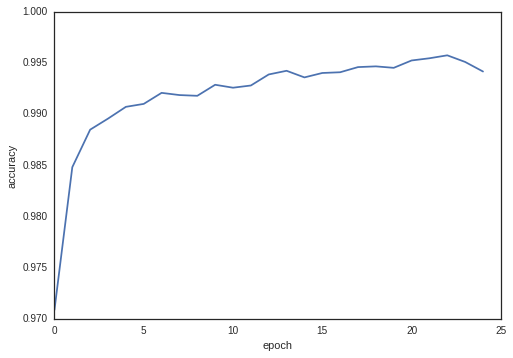

In [37]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(history.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")


From above we can see after epoch:22 the accuracy has started decreasing as same as per train accuracy graph nature. It increase then start overfitting then start decreasing.